## Predictive modeling of customer bookings

### Exploratory data analysis

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

In [4]:
# check on unique flight days
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [5]:
# create a dictionary to map the flight days to numbers
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [6]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [7]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


#### Sales Channel

In [8]:
# check value counts for sales channel
df["sales_channel"].value_counts()

Internet    44382
Mobile       5618
Name: sales_channel, dtype: int64

More people prefer to book through the internet than over a phone call.

#### Trip Type

In [10]:
# check value counts for trip type
df["trip_type"].value_counts()

RoundTrip     49497
OneWay          387
CircleTrip      116
Name: trip_type, dtype: int64

<AxesSubplot:xlabel='purchase_lead', ylabel='Count'>

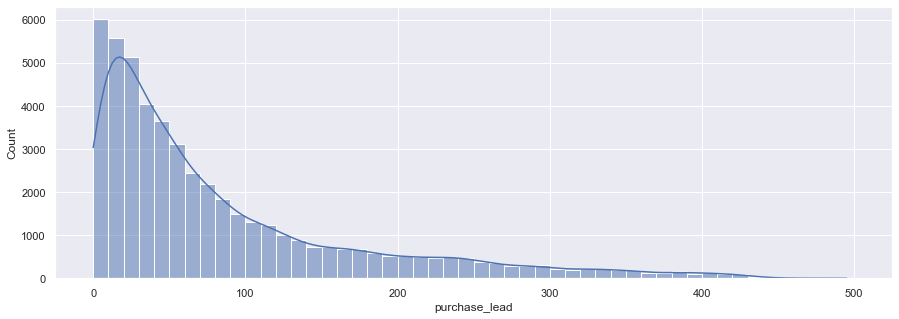

In [44]:
# plot the distribution of the purchase lead time using seaborn
plt.figure(figsize=(15, 5))
sns.histplot(df["purchase_lead"], binwidth=10, kde=True)

There are few bookings that were done more than 2 years before the travel date and it seems very unlikely that book that in advance. However, it might also be because of the cancellation and rebooking in a period of 6 months for twice. Generally airline keep the tickets for rebooking within a year, so we can consider these rare bookings as outliers.

#### Purchase Lead Time

In [29]:
# count how manybookings are above 500 days
(df["purchase_lead"] > 500).value_counts()

False    49982
True        18
Name: purchase_lead, dtype: int64

In [31]:
# remove the bookings with a purchase lead time above 500 days
df = df[df["purchase_lead"] <= 500]

#### Length of Stay

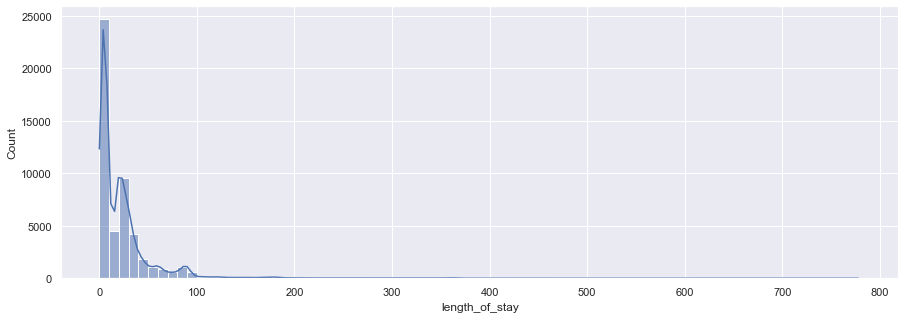

In [47]:
# check the distribution for length of stay
plt.figure(figsize=(15, 5))
sns.histplot(df["length_of_stay"], binwidth=10, kde=True);

In [53]:
# find out how many bookings have a length of stay above 365 days
(df["length_of_stay"] > 365).value_counts()

False    49959
True        23
Name: length_of_stay, dtype: int64

In [54]:
# remove the bookings with a length of stay above 365 days
df = df[df["length_of_stay"] <= 365]

#### Flight Day

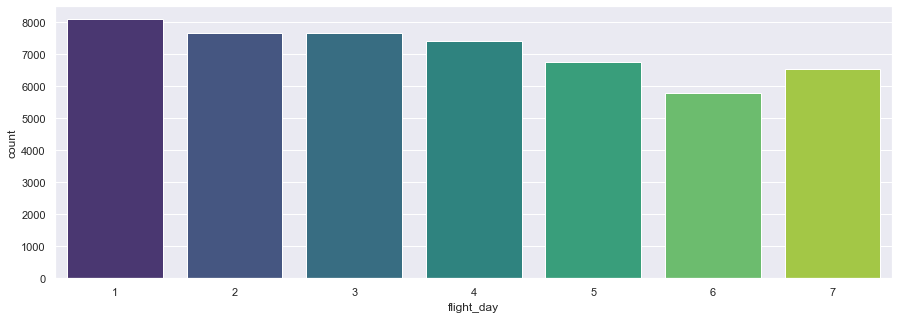

In [70]:
# plot flight day distribution
plt.figure(figsize=(15, 5))
sns.countplot(x="flight_day", data=df, palette="viridis");

#### Flight Hour

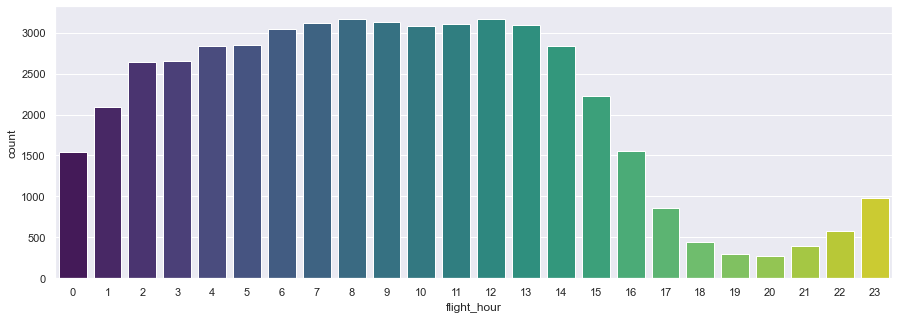

In [73]:
# plot flight hour distribution
plt.figure(figsize=(15, 5))
sns.countplot(x="flight_hour", data=df, palette="viridis");

#### Booking Origin

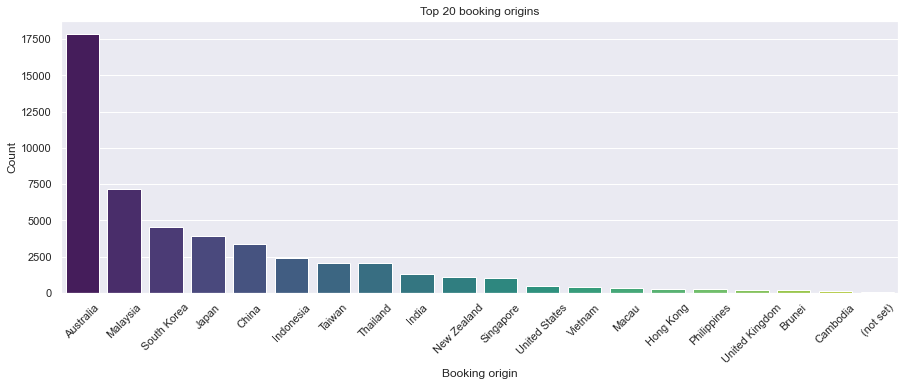

In [88]:
# plot the top 20 booking origins, sorted by booking origin, tilt x-axis labels
plt.figure(figsize=(15, 5))
sns.countplot(
    x="booking_origin",
    data=df,
    palette="viridis",
    order=df["booking_origin"].value_counts().iloc[:20].index)

# Plot labels
plt.title("Top 20 booking origins")
plt.xlabel("Booking origin")
plt.ylabel("Count")
plt.xticks(rotation=45);

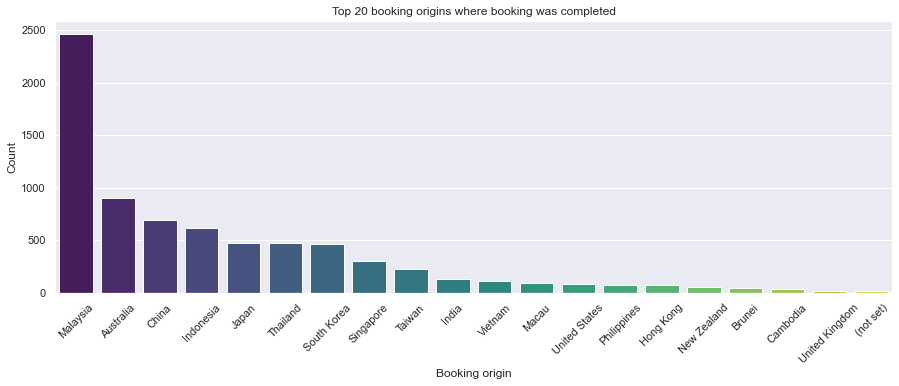

In [98]:
# plot and sort top 20 booking origins where passengers completed the booking
plt.figure(figsize=(15, 5))
sns.countplot(
    x="booking_origin",
    data=df[df["booking_complete"] == 1],
    palette="viridis",
    order=df[df["booking_complete"] == 1]["booking_origin"].value_counts().iloc[:20].index)

# Plot labels
plt.title("Top 20 booking origins where booking was completed")
plt.xlabel("Booking origin")
plt.ylabel("Count")
plt.xticks(rotation=45);

#### Booking Completed

In [100]:
# count how many bookings are completed
df["booking_complete"].value_counts(normalize=True)

0    0.850477
1    0.149523
Name: booking_complete, dtype: float64

Only 15% of all bookings were successfully completed.

In [101]:
# save the cleaned data to a new csv file
df.to_csv("data/customer_booking_cleaned.csv", index=False)